# LSTM For Predictive Maintenance

# **Cargando las Librerías**

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns    
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

Using TensorFlow backend.


# **Cargando el Dataset**

In [2]:
dataset_train=pd.read_csv('../input/PM_train.txt',sep=' ',header=None).drop([26,27],axis=1)
col_names = ['id','cycle','setting1','setting2','setting3','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']
dataset_train.columns=col_names
print('Shape of Train dataset: ',dataset_train.shape)
dataset_train.head()

Shape of Train dataset:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [3]:
dataset_test=pd.read_csv('../input/PM_test.txt',sep=' ',header=None).drop([26,27],axis=1)
dataset_test.columns=col_names
#dataset_test.head()
print('Shape of Test dataset: ',dataset_train.shape)
dataset_test.head()

Shape of Test dataset:  (20631, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


# **Cargando el archivo TRUTH que tiene como datos el Target del Dataset**

In [4]:
pm_truth=pd.read_csv('../input/PM_truth.txt',sep=' ',header=None).drop([1],axis=1)
pm_truth.columns=['more']
pm_truth['id']=pm_truth.index+1
pm_truth.head()

,more,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


In [5]:
# generamos la columna maxima para el resto de los datos
rul = pd.DataFrame(dataset_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
rul.head()

,id,max
0,1,31
1,2,49
2,3,126
3,4,106
4,5,98


In [6]:
# generamos la columna maxima para la falla
pm_truth['rtf']=pm_truth['more']+rul['max']
pm_truth.head()

,more,id,rtf
0,112,1,143
1,98,2,147
2,69,3,195
3,82,4,188
4,91,5,189


In [7]:
#hacemos merge de los dataset truth y test
pm_truth.drop('more', axis=1, inplace=True)
dataset_test=dataset_test.merge(pm_truth,on=['id'],how='left')
dataset_test['ttf']=dataset_test['rtf'] - dataset_test['cycle']
dataset_test.drop('rtf', axis=1, inplace=True)
dataset_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


In [8]:
dataset_train['ttf'] = dataset_train.groupby(['id'])['cycle'].transform(max)-dataset_train['cycle']
dataset_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [9]:
#Generamos el label_bc para arriba de 30 ciclos
df_train=dataset_train.copy()
df_test=dataset_test.copy()
period=30
df_train['label_bc'] = df_train['ttf'].apply(lambda x: 1 if x <= period else 0)
df_test['label_bc'] = df_test['ttf'].apply(lambda x: 1 if x <= period else 0)
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf,label_bc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


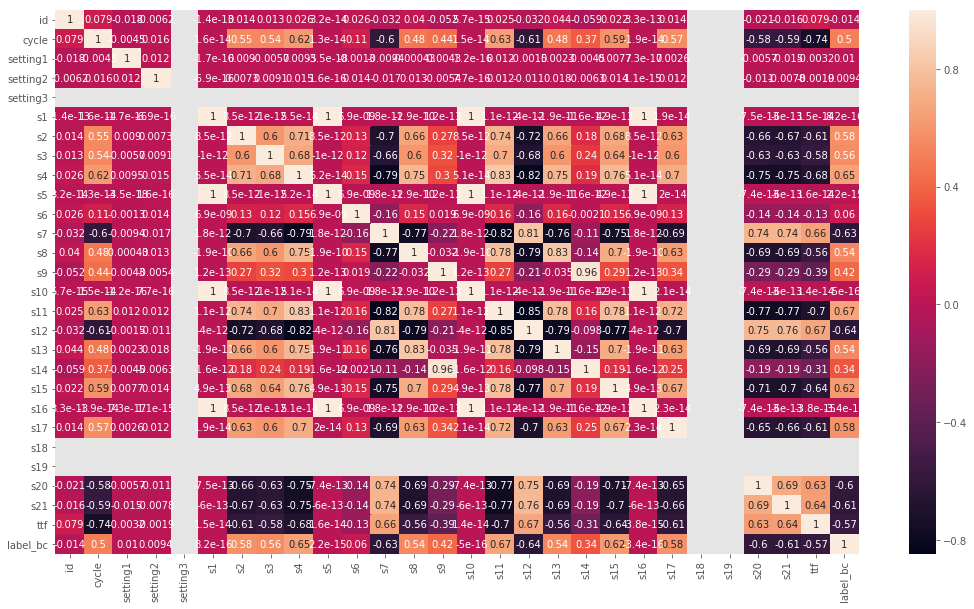

In [10]:
corr = df_train.corr()
plt.figure(figsize=(18,10))
sns.heatmap(corr, annot = True)
plt.show()

# **Aplicando PCA**

In [11]:
dataset_train_pca = df_train.drop(['id','cycle','setting1','setting2','setting3','ttf','label_bc'],axis=1) 

In [12]:
dataset_train_no_pca = df_train.drop(['setting3','s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
                   's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21'],axis=1) 

In [13]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(dataset_train_pca)
np.mean(x),np.std(x)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:616: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:459: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(-0.09523809523834474, 0.8946806775264466)

In [14]:
feat_cols = ['Feature'+str(i) for i in range(x.shape[1])]
norm_df = pd.DataFrame(x,columns=feat_cols)
norm_df.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,Feature16,Feature17,Feature18,Feature19,Feature20
0,0.0,-1.721725,-0.134255,-0.925936,-1.0,0.141683,1.121141,-0.516338,-0.862813,0.0,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-1.0,-0.781710,0.0,0.0,1.348493,1.194427
1,0.0,-1.061780,0.211528,-0.643726,-1.0,0.141683,0.431930,-0.798093,-0.958818,0.0,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-1.0,-0.781710,0.0,0.0,1.016528,1.236922
2,0.0,-0.661813,-0.413166,-0.525953,-1.0,0.141683,1.008155,-0.234584,-0.557139,0.0,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-1.0,-2.073094,0.0,0.0,0.739891,0.503423
3,0.0,-0.661813,-1.261314,-0.784831,-1.0,0.141683,1.222827,0.188048,-0.713826,0.0,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-1.0,-0.781710,0.0,0.0,0.352598,0.777792
4,0.0,-0.621816,-1.251528,-0.301518,-1.0,0.141683,0.714393,-0.516338,-0.457059,0.0,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-1.0,-0.136018,0.0,0.0,0.463253,1.059552


In [15]:
cov_x = np.cov(x.T) #Calculo de la covarianza
eig_vals, eig_vecs = np.linalg.eig(cov_x) 

In [16]:
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
print('Eigenvalores ordenados:')
for i in eig_pairs:
    print(i[0])

Eigenvalores ordenados:
9.026834847212685
2.098642321494198
0.9664790535206507
0.41395209342969785
0.3683014084514325
0.34833307191389334
0.306124650912546
0.28980431729452627
0.2554174802622784
0.20619623347972033
0.19602838643885453
0.17658931901159577
0.17255633364765446
0.14619238956920277
0.02927518982255789
0.0
0.0
0.0
0.0
0.0
0.0


In [17]:
matrix_w = np.hstack((eig_pairs[0][1].reshape(21,1),
                      eig_pairs[1][1].reshape(21,1),
                      eig_pairs[2][1].reshape(21,1),
                      eig_pairs[3][1].reshape(21,1),
                      eig_pairs[4][1].reshape(21,1),
                      eig_pairs[5][1].reshape(21,1),
                      eig_pairs[6][1].reshape(21,1),
                      eig_pairs[7][1].reshape(21,1)))

print('Matriz de Covarianza:\n', matrix_w)

Y = x.dot(matrix_w)

Matriz de Covarianza:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.27274481  0.01828501 -0.02193832 -0.18985107 -0.55520692 -0.73623472
   0.07569523  0.09175744]
 [-0.2596079   0.07736212 -0.03074191  0.93397407  0.08059956 -0.1666274
   0.04767504  0.05545754]
 [-0.30058958  0.01047153 -0.01780016 -0.03529215 -0.03126277  0.0930184
   0.01615535 -0.06757603]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.06234603 -0.04784759  0.99661875  0.0171976  -0.00179873 -0.00954941
  -0.00450775  0.01000594]
 [ 0.29785673  0.05160072  0.01637791  0.02923834 -0.01037273 -0.09243643
   0.01346307  0.05931796]
 [-0.28127596 -0.24317902 -0.03189912 -0.02097231  0.00319922  0.04396233
  -0.01467761 -0.06702373]
 [-0.10534846  0.64336949  0.02628801 -0.04601634 -0.04199692  0.05635896
  -0.01667691 -0.03972091]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.   

In [18]:
pca_imp_df = pd.DataFrame(data = Y, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8'])
pca_imp_df.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
0,2.944902,-0.452747,0.300691,0.824244,0.629020,0.344302,-0.032812,-0.635351
1,2.360407,-0.795862,0.248736,0.961509,0.285420,0.022143,0.303058,-0.648289
2,2.979360,-0.549591,0.290127,0.603968,-1.100258,0.457617,-0.230811,-0.106652
3,3.384948,-0.841757,0.305124,-0.404573,-0.052269,-0.126706,0.112252,1.127880
4,2.422708,-0.377598,0.289617,-0.716113,0.360137,-0.072907,0.494492,-0.223097


In [19]:
pca_imp_df

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
0,2.944902,-0.452747,0.300691,0.824244,0.629020,0.344302,-0.032812,-0.635351
1,2.360407,-0.795862,0.248736,0.961509,0.285420,0.022143,0.303058,-0.648289
2,2.979360,-0.549591,0.290127,0.603968,-1.100258,0.457617,-0.230811,-0.106652
3,3.384948,-0.841757,0.305124,-0.404573,-0.052269,-0.126706,0.112252,1.127880
4,2.422708,-0.377598,0.289617,-0.716113,0.360137,-0.072907,0.494492,-0.223097
5,3.660531,-0.506428,0.344887,0.099233,-0.299077,0.405627,-0.209158,-0.032698
6,3.162794,-0.086253,0.308973,1.054236,-0.014133,-0.928852,-0.396064,0.051090
7,3.333121,-0.732464,0.315175,-0.334072,-0.826816,-0.090102,-0.518250,0.309919
8,3.231518,-0.985188,0.274392,1.036175,0.424345,-0.380938,-0.185611,0.468666
9,2.853438,-0.654615,0.286306,0.922791,1.330979,0.371382,0.755444,-0.569841


In [20]:
dataset_train_no_pca= dataset_train_no_pca.join(pca_imp_df,lsuffix='_caller', rsuffix='_other')

In [21]:
dataset_train_no_pca

,id,cycle,setting1,setting2,ttf,label_bc,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
0,1,1,-0.0007,-0.0004,191,0,2.944902,-0.452747,0.300691,0.824244,0.629020,0.344302,-0.032812,-0.635351
1,1,2,0.0019,-0.0003,190,0,2.360407,-0.795862,0.248736,0.961509,0.285420,0.022143,0.303058,-0.648289
2,1,3,-0.0043,0.0003,189,0,2.979360,-0.549591,0.290127,0.603968,-1.100258,0.457617,-0.230811,-0.106652
3,1,4,0.0007,0.0000,188,0,3.384948,-0.841757,0.305124,-0.404573,-0.052269,-0.126706,0.112252,1.127880
4,1,5,-0.0019,-0.0002,187,0,2.422708,-0.377598,0.289617,-0.716113,0.360137,-0.072907,0.494492,-0.223097
5,1,6,-0.0043,-0.0001,186,0,3.660531,-0.506428,0.344887,0.099233,-0.299077,0.405627,-0.209158,-0.032698
6,1,7,0.0010,0.0001,185,0,3.162794,-0.086253,0.308973,1.054236,-0.014133,-0.928852,-0.396064,0.051090
7,1,8,-0.0034,0.0003,184,0,3.333121,-0.732464,0.315175,-0.334072,-0.826816,-0.090102,-0.518250,0.309919
8,1,9,0.0008,0.0001,183,0,3.231518,-0.985188,0.274392,1.036175,0.424345,-0.380938,-0.185611,0.468666
9,1,10,-0.0033,0.0001,182,0,2.853438,-0.654615,0.286306,0.922791,1.330979,0.371382,0.755444,-0.569841


In [22]:
dataset_test_pca = df_test.drop(['id','cycle','setting1','setting2','setting3','ttf','label_bc'],axis=1) 

In [23]:
dataset_test_no_pca = df_test.drop(['setting3','s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
                   's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21'],axis=1) 

In [24]:
from sklearn.preprocessing import StandardScaler
x2 = StandardScaler().fit_transform(dataset_test_pca)
np.mean(x2),np.std(x2)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:616: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:459: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(-0.14285714285707665, 0.9147320339189888)

In [25]:
feat_cols2 = ['Feature'+str(i) for i in range(x2.shape[1])]
norm2_df = pd.DataFrame(x2,columns=feat_cols2)
norm2_df.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,Feature16,Feature17,Feature18,Feature19,Feature20
0,0.0,1.359276,-0.561495,-0.975674,-1.0,0.17566,0.209138,-0.539078,-0.720312,-1.0,-1.103591,-0.049542,-0.720590,-1.315031,-0.711659,-1.0,-0.463406,0.0,0.0,-0.229408,0.448866
1,0.0,-1.908502,0.070116,-1.392836,-1.0,0.17566,1.603612,-1.061366,-0.348673,-1.0,0.427727,0.736727,-0.193647,0.065977,-1.570037,-1.0,0.347276,0.0,0.0,0.899934,0.664042
2,0.0,-0.037636,-0.231698,-0.507676,-1.0,0.17566,0.517390,-0.364982,-0.126564,-1.0,0.427727,0.397202,-0.720590,-0.868436,0.629340,-1.0,0.347276,0.0,0.0,1.323438,0.961247
3,0.0,-0.087526,-0.795350,0.251888,-1.0,0.17566,0.458675,-0.713174,-1.147041,-1.0,-0.695239,-0.657113,-0.369295,-0.593609,-1.177045,-1.0,-1.274088,0.0,0.0,0.758766,0.451244
4,0.0,0.087088,-0.181729,-0.420954,-1.0,0.17566,0.590783,-1.061366,-1.211750,-1.0,-0.542108,0.718857,-0.720590,-0.923402,-0.784053,-1.0,-2.084769,0.0,0.0,0.688182,0.918450


In [26]:
cov_x2 = np.cov(x2.T) #Calculo de la covarianza
eig_vals2, eig_vecs2 = np.linalg.eig(cov_x2) 

In [27]:
eig_pairs2 = [(np.abs(eig_vals2[i]), eig_vecs2[:,i]) for i in range(len(eig_vals2))]
eig_pairs2.sort(key=lambda x2: x2[0], reverse=True)
print('Eigenvalores ordenados:')
for i in eig_pairs:
    print(i[0])

Eigenvalores ordenados:
9.026834847212685
2.098642321494198
0.9664790535206507
0.41395209342969785
0.3683014084514325
0.34833307191389334
0.306124650912546
0.28980431729452627
0.2554174802622784
0.20619623347972033
0.19602838643885453
0.17658931901159577
0.17255633364765446
0.14619238956920277
0.02927518982255789
0.0
0.0
0.0
0.0
0.0
0.0


In [28]:
matrix_w2 = np.hstack((eig_pairs[0][1].reshape(21,1),
                      eig_pairs[1][1].reshape(21,1),
                      eig_pairs[2][1].reshape(21,1),
                      eig_pairs[3][1].reshape(21,1),
                      eig_pairs[4][1].reshape(21,1),
                      eig_pairs[5][1].reshape(21,1),
                      eig_pairs[6][1].reshape(21,1),
                      eig_pairs[7][1].reshape(21,1)))

print('Matriz de Covarianza:\n', matrix_w2)

Y2 = x2.dot(matrix_w2)

Matriz de Covarianza:
 [[ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.27274481  0.01828501 -0.02193832 -0.18985107 -0.55520692 -0.73623472
   0.07569523  0.09175744]
 [-0.2596079   0.07736212 -0.03074191  0.93397407  0.08059956 -0.1666274
   0.04767504  0.05545754]
 [-0.30058958  0.01047153 -0.01780016 -0.03529215 -0.03126277  0.0930184
   0.01615535 -0.06757603]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.06234603 -0.04784759  0.99661875  0.0171976  -0.00179873 -0.00954941
  -0.00450775  0.01000594]
 [ 0.29785673  0.05160072  0.01637791  0.02923834 -0.01037273 -0.09243643
   0.01346307  0.05931796]
 [-0.28127596 -0.24317902 -0.03189912 -0.02097231  0.00319922  0.04396233
  -0.01467761 -0.06702373]
 [-0.10534846  0.64336949  0.02628801 -0.04601634 -0.04199692  0.05635896
  -0.01667691 -0.03972091]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.   

In [29]:
pca_imp_df2 = pd.DataFrame(data = Y2, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8'])
pca_imp_df2.head()

,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
0,1.352784,-1.102445,0.192571,-0.410697,-1.007725,-1.190438,0.500795,0.806803
1,2.663381,0.155284,0.341792,0.733308,1.579634,0.103850,-0.249893,0.650969
2,1.102540,-0.389144,0.234978,-0.056249,0.514606,-0.875832,0.108816,-1.298538
3,1.781158,-1.094906,0.229821,-0.093977,-0.839068,-0.079948,-0.298794,0.250614
4,2.629465,-1.116502,0.273455,0.725626,-1.472957,-0.180968,0.181238,-0.023469


In [30]:
dataset_test_no_pca= dataset_test_no_pca.join(pca_imp_df2,lsuffix='_caller', rsuffix='_other')

# **Seleccionamos los Features y el Target**

In [31]:
features_col_name=['setting1', 'setting2', 'PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8']
target_col_name='label_bc'

In [32]:
sc=MinMaxScaler()
dataset_train_no_pca[features_col_name]=sc.fit_transform(dataset_train_no_pca[features_col_name])
dataset_test_no_pca[features_col_name]=sc.transform(dataset_test_no_pca[features_col_name])

In [33]:
dataset_train_no_pca

,id,cycle,setting1,setting2,ttf,label_bc,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8
0,1,1,0.459770,0.166667,191,0,0.788064,0.269343,0.961259,0.656637,0.606420,0.602446,0.520093,0.384598
1,1,2,0.609195,0.250000,190,0,0.755271,0.243809,0.954547,0.684277,0.536345,0.533645,0.589751,0.381597
2,1,3,0.252874,0.750000,189,0,0.789997,0.262136,0.959894,0.612282,0.253744,0.626646,0.479030,0.507246
3,1,4,0.540230,0.500000,188,0,0.812753,0.240393,0.961832,0.409200,0.467475,0.501856,0.550179,0.793633
4,1,5,0.390805,0.333333,187,0,0.758766,0.274936,0.959828,0.346468,0.551583,0.513345,0.629453,0.480233
5,1,6,0.252874,0.416667,186,0,0.828214,0.265348,0.966968,0.510647,0.417140,0.615543,0.483520,0.524402
6,1,7,0.557471,0.583333,185,0,0.800289,0.296617,0.962329,0.702948,0.475253,0.330546,0.444757,0.543839
7,1,8,0.304598,0.750000,184,0,0.809845,0.248527,0.963130,0.423397,0.309511,0.509673,0.419416,0.603882
8,1,9,0.545977,0.583333,183,0,0.804144,0.229719,0.957862,0.699311,0.564678,0.447561,0.488404,0.640708
9,1,10,0.310345,0.583333,182,0,0.782932,0.254320,0.959401,0.676480,0.749581,0.608230,0.683573,0.399795


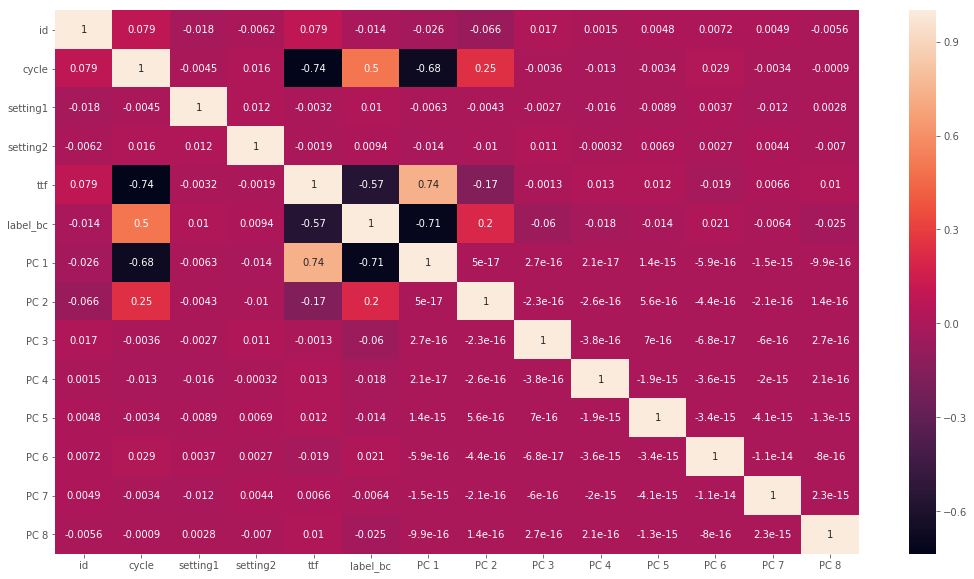

In [34]:
corr = dataset_train_no_pca.corr()
plt.figure(figsize=(18,10))
sns.heatmap(corr, annot = True)
plt.show()

In [35]:
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# función para generar la etiqueta 'label'
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [36]:
# marca de tiempo o tamaño de ventana 
seq_length=50
seq_cols=features_col_name

In [37]:
# Generamos el X_train
X_train=np.concatenate(list(list(gen_sequence(dataset_train_no_pca[dataset_train_no_pca['id']==id], seq_length, seq_cols)) for id in dataset_train_no_pca['id'].unique()))
print(X_train.shape)
# Generamos el Y_train
y_train=np.concatenate(list(list(gen_label(dataset_train_no_pca[dataset_train_no_pca['id']==id], 50, seq_cols,'label_bc')) for id in dataset_train_no_pca['id'].unique()))
print(y_train.shape)

(20531, 50, 10)
(20531,)


In [38]:
# Generamos X_test
X_test=np.concatenate(list(list(gen_sequence(dataset_test_no_pca[dataset_test_no_pca['id']==id], seq_length, seq_cols)) for id in dataset_test_no_pca['id'].unique()))
print(X_test.shape)
# Generamos y_test
y_test=np.concatenate(list(list(gen_label(dataset_test_no_pca[dataset_test_no_pca['id']==id], 50, seq_cols,'label_bc')) for id in dataset_test_no_pca['id'].unique()))
print(y_test.shape)

(12996, 50, 10)
(12996,)


In [39]:
nb_features =X_train.shape[2]
timestamp=seq_length

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           44400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 74,651
Trainable params: 74,651
Non-trainable params: 0
_________________________________________________________________


In [40]:
# ajustamos el modelo
model.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Train on 19504 samples, validate on 1027 samples
Epoch 1/10
19504/19504 [==============================] - 28s 1ms/step - loss: 0.2965 - acc: 0.8934 - val_loss: 0.1302 - val_acc: 0.9484
Epoch 2/10
19504/19504 [==============================] - 26s 1ms/step - loss: 0.1078 - acc: 0.9563 - val_loss: 0.0814 - val_acc: 0.9649
Epoch 3/10
19504/19504 [==============================] - 26s 1ms/step - loss: 0.0913 - acc: 0.9622 - val_loss: 0.0713 - val_acc: 0.9718
Epoch 4/10
19504/19504 [==============================] - 26s 1ms/step - loss: 0.0788 - acc: 0.9673 - val_loss: 0.0526 - val_acc: 0.9805
Epoch 5/10
19504/19504 [==============================] - 26s 1ms/step - loss: 0.0693 - acc: 0.9706 - val_loss: 0.0532 - val_acc: 0.9776


In [41]:
# Entrenamos las métricas
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

20531/20531 [==============================] - 8s 367us/step
Accurracy: 0.9728215923468884


In [42]:
y_pred=model.predict_classes(X_test)
print('Accuracy del modelo: ',accuracy_score(y_test,y_pred))
print('Matríz de Confusión: \n',confusion_matrix(y_test,y_pred))

Accuracy del modelo:  0.927670052323792
Matríz de Confusión: 
 [[11724   940]
 [    0   332]]


Train on 20531 samples, validate on 12996 samples
Epoch 1/20
20531/20531 [==============================] - 32s 2ms/step - loss: 0.0693 - acc: 0.9706 - val_loss: 0.1523 - val_acc: 0.9518
Epoch 2/20
20531/20531 [==============================] - 31s 2ms/step - loss: 0.0695 - acc: 0.9704 - val_loss: 0.1551 - val_acc: 0.9518
Epoch 3/20
20531/20531 [==============================] - 32s 2ms/step - loss: 0.0639 - acc: 0.9728 - val_loss: 0.1197 - val_acc: 0.9608
Epoch 4/20
20531/20531 [==============================] - 32s 2ms/step - loss: 0.0691 - acc: 0.9703 - val_loss: 0.1858 - val_acc: 0.9415
Epoch 5/20
20531/20531 [==============================] - 32s 2ms/step - loss: 0.0562 - acc: 0.9769 - val_loss: 0.2987 - val_acc: 0.9124
Epoch 6/20
20531/20531 [==============================] - 32s 2ms/step - loss: 0.0537 - acc: 0.9762 - val_loss: 0.2445 - val_acc: 0.9347
Epoch 7/20
20531/20531 [==============================] - 32s 2ms/step - loss: 0.0579 - acc: 0.9758 - val_loss: 0.1564 - val_acc

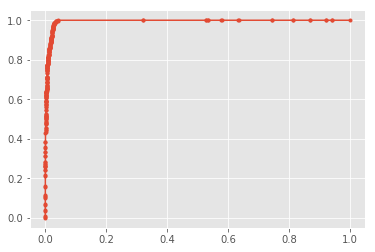

In [43]:
from sklearn.metrics import roc_curve, auc

history = model.fit(X_train, y_train, validation_data=(
        X_test, y_test), epochs=20, batch_size=200, verbose=1)

y_pred = model.predict(X_test).ravel()

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.2f)' % auc_keras)

In [44]:
def prob_failure(machine_id):
    machine_df=dataset_test_no_pca[dataset_test_no_pca.id==machine_id]
    machine_test=gen_sequence(machine_df,seq_length,seq_cols)
    m_pred=model.predict(machine_test)
    failure_prob=list(m_pred[-1]*100)[0]
    return failure_prob

In [45]:
machine_id=16
print('Probabilidad que la maquina falle en 30 días: ',prob_failure(machine_id))

Probabilidad que la maquina falle en 30 días:  0.018496083


In [46]:
from sklearn.metrics import accuracy_score
y_pred=model.predict_classes(X_test)
accuracy_score(y_test, y_pred)



0.951061865189289

In [47]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='macro')

0.7425059502299094

In [48]:
f1_score(y_test, y_pred, average='micro')

0.9510618651892891

In [49]:
f1_score(y_test, y_pred, average='weighted')

0.9624026280068477

In [50]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)


0.9748894504106127

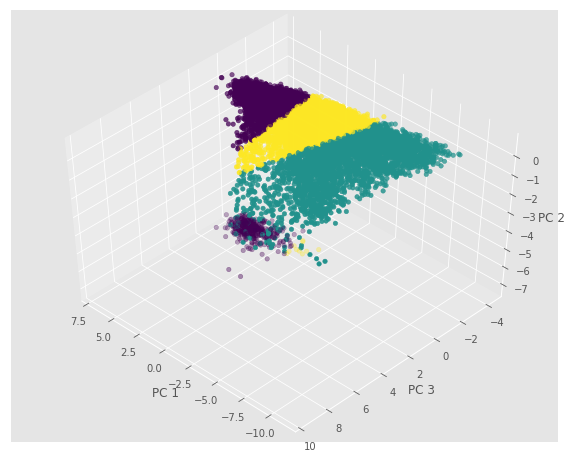

In [51]:
K = 3
k_means = KMeans(init = "k-means++", n_clusters = K, n_init = 12)
k_means.fit(pca_imp_df)

aux=np.array(pca_imp_df)

labels = k_means.labels_ 

fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
ax.set_xlabel('PC 1')
ax.set_zlabel('PC 2')
ax.set_ylabel('PC 3')

ax.scatter(aux[:, 0], aux[:, 1], aux[:, 2], c= labels.astype(np.float))